In [4]:
# $B_s \rightarrow KK\mu\mu$ Documentation

This investigation has been detailed in 2 parts:
1. Background Reduction and Decay Reconstruction
2. Machine Learning and Branching Fraction (this notebook)


# Colab Notebook Setup

## Packages

While the Colab Notebook comes with `xgboost` installed, we have found it more suitable to upgrade it to the latest 1.X version instead of the preinstalled 0.9.0 due to increased stability in terms of model IO (i.e. saving to JSON).

In [5]:
#!pip install --upgrade xgboost

In [6]:
"""
=============
plot settings
=============
"""

override = {
   'axes.labelsize':40,
   'font.size': 40,
   'legend.fontsize': 40,
   'legend.framealpha': 1,
   'legend.edgecolor': 'black',
   'grid.color': 'gainsboro',
   'grid.linewidth': 1.75,
   'xtick.labelsize': 40,
   'ytick.labelsize': 40,
   'figure.figsize': [13, 10],
   'lines.linewidth': 3,
   'font.family': 'DejaVu Sans',
   'mathtext.fontset': 'cm',
   'text.usetex': True
   } 

overridesmall = {
   'axes.labelsize':28,
   'font.size': 28,
   'legend.fontsize': 32,
   'legend.framealpha': 1,
   'legend.edgecolor': 'black',
   'grid.color': 'gainsboro',
   'xtick.labelsize': 28,
   'ytick.labelsize': 28,   
   'figure.figsize': [11, 8.5],
   'lines.linewidth': 3,
   'font.sans-serif': 'Computer Modern Sans serif',
   'mathtext.fontset': 'cm'
   } 

colors=["indianred","dodgerblue","darkorange","forestgreen","hotpink",
        "cornflowerblue","darkgoldenrod","sienna","yellowgreen","tomato"]

## Data

Let's load the data tuple:

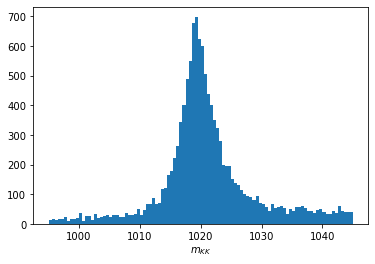

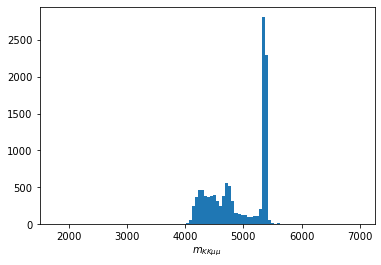

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

Bs_df = pd.read_pickle('Bs_reduced_tau_reconstructed_data_frame_SL.pkl.gz')


phijpsimask=(((Bs_df['phi3_M']>995) & (Bs_df['phi3_M']<1045))  
            & ((Bs_df['jpsi_M']>2800) & (Bs_df['jpsi_M']<3300)))


Bs_df=Bs_df.loc[phijpsimask]

plt.figure()
plt.hist(Bs_df['phi3_M'], bins=100)
plt.xlabel("$m_{KK}$")

plt.figure()
plt.hist(Bs_df['Bs_M'],bins=100)
plt.xlabel("$m_{KK \mu \mu}$")
plt.show()

Now the MC tuple, that we thruthmatch:

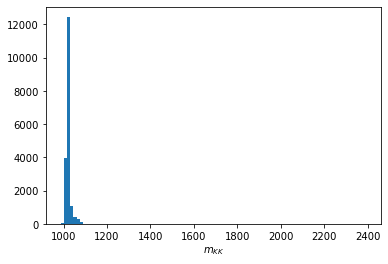

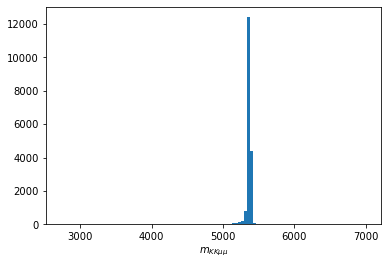

In [8]:
Bs_df_signal = pd.read_pickle('Bs_reduced_tau_reconstructed_data_frame_MC_phimumu.pkl.gz')

signal_mask= (
    (Bs_df_signal['K_plus_TRUEID']==321) & (Bs_df_signal['K_minus_TRUEID']==-321) &
    ((Bs_df_signal['mu_minus_MC_MOTHER_ID']==531)|(Bs_df_signal['mu_minus_MC_MOTHER_ID']==-531))
)


Bs_df_signal=Bs_df_signal.loc[signal_mask]

plt.figure()
plt.hist(Bs_df_signal['phi_M'], bins=100)
plt.xlabel("$m_{KK}$")

plt.figure()
plt.hist(Bs_df_signal['Bs_M'],bins=100)
plt.xlabel("$m_{KK \mu \mu}$")
plt.show()

In [9]:
def event_counter(data_frame):
    actual_events=[]
    counter=0
    event_number=data_frame['eventNumber'].to_numpy()
    run_number=data_frame['eventNumber'].to_numpy()
    for i in range(len(event_number)):
        if (event_number[i] in actual_events)==False:
            actual_events.append(event_number[i])
            counter+=1
    return counter

print(event_counter(Bs_df_signal))

17148


## Utilities

In [10]:
import numpy as np
import pandas as pd
from typing import List, Optional
import matplotlib.pyplot as plt

masses = {'mu': 105.658, 'tau': 1777, 'proton': 938.272, 'K': 493.677, 'pi': 139.57, 'D0': 1865,
          'J/psi': 3097, 'psi(2S)': 3686, 'rho0': 770, 'rho1450': 1450, 'kstar': 892,
          'Lc': 2286, 'Lb': 5620, 'B': 5279}


def get_mass(data_frame: pd.DataFrame, particles_associations: List[List[str]]) -> pd.DataFrame:
    """
    Obtains the mass of different associations of particles
    :param data_frame:
    :param particles_associations: list of lists made of ['particle_P', 'particle']
    :return:
    """
    energy_series = [
        (data_frame.loc[:, particle_P] ** 2 + masses[particle] ** 2) ** 0.5
        for particle_P, particle in particles_associations
    ]
    energy = pd.concat(energy_series, axis=1).sum(axis=1)
    
    particle_Ps = [i[0] for i in particles_associations]
    
    momentums = {}
    for coord in ['X', 'Y', 'Z']:
        particle_P_coords = [f'{particle_P}{coord}' for particle_P in particle_Ps]
        momentum_series = data_frame.loc[:, particle_P_coords].sum(axis=1)
        momentums[coord] = momentum_series
    sum_momenta = (pd.concat(momentums.values(), axis=1) ** 2).sum(axis=1)
    mass = (energy ** 2 - sum_momenta) ** 0.5
    return mass


In [28]:
'''BDT_COLUMNS = ['Bs_OWNPV_IPCHI2','mu_plus_IPCHI2_OWNPV','mu_minus_IPCHI2_OWNPV','K_plus_IPCHI2_OWNPV','K_minus_IPCHI2_OWNPV','Bs_PT','Bs_ENDVERTEX_CHI2','Bs_FDCHI2_OWNPV',
               'mu_plus_PIDmu','mu_minus_PIDmu','K_plus_PIDK','K_minus_PIDK','Bs_DIRA_OWNPV'         
              ]
'''
BDT_COLUMNS = ['Bs_MINIPCHI2','muplus_MINIPCHI2','muminus_MINIPCHI2','Kplus_MINIPCHI2','Kminus_MINIPCHI2','Bs_PT','Bs_VCHI2', 
               'muplus_RichDLLmu','muminus_RichDLLmu','Kplus_RichDLLk','Kminus_RichDLLK'         
              ]


particles_associations = [['Kminus_P', 'K'], ['Kplus_P', 'K'], ['muminus_P', 'mu'], ['muplus_P', 'mu']]
Bs_df['_kkmumu_mass'] = get_mass(data_frame=Bs_df, particles_associations=particles_associations)

# Signal region

## Finding the signal region

In [13]:
import numpy as np

percentiles = [0.00135, 0.02275, 0.1, 0.25, 0.5]

def find_cutoff_at_percentiles(array: np.ndarray):
    _percentiles = sorted(list(set(percentiles + [1 - _p for _p in percentiles])))

    cutoff_values = np.quantile(array, _percentiles)
    print("\n".join([f"{_percentile:.5f}\t{_cutoff:.0f}" for _percentile, _cutoff in zip(_percentiles, cutoff_values)]))
    return cutoff_values


0.00135	5201
0.02275	5235
0.10000	5323
0.25000	5351
0.50000	5365
0.75000	5379
0.90000	5391
0.97725	5410
0.99865	5448


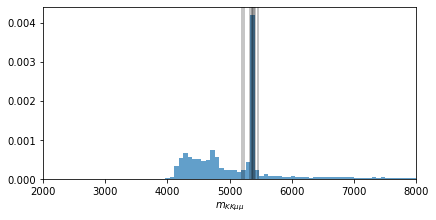

In [14]:
import matplotlib.pyplot as plt

_b_mass_distribution = Bs_df['_kkmumu_mass']

plt.figure(figsize=(6, 3))

for quantile in find_cutoff_at_percentiles(_b_mass_distribution.loc[(_b_mass_distribution > 5200) & (_b_mass_distribution < 5450)]):
    plt.axvline(quantile, color='k', alpha=0.3)

n, bins, patches = plt.hist(_b_mass_distribution, range=[0, 8e3], bins='auto', alpha=0.7, density=True)
plt.xlim((2e3, 8e3))
plt.xlabel(r'$m_{K K \mu \mu}$')
plt.tight_layout(pad=0.5)
plt.show()


In [15]:
Bs_signal_region = [5275, 5407]

We have defined the signal region as the region inclusive of the $\pm 2 \sigma$ region of a normal distribution.

I.e. The mass limits that cover the 2.275th percentile to the 97.725th percentile.

In [16]:
_kkmumu_mass = 5366

def get_bs_kkmumu_mass_cut_mask(data_frame):
    """
    Returns a boolean mask that removes the lb -> pkmumu peak.
    I.e. False when event would fall inside the pkmumu peak.
    """
    _kkmumu_mass_width = 150

    mass_cut_mask = (data_frame._kkmumu_mass > _kkmumu_mass + _kkmumu_mass_width) | (data_frame._kkmumu_mass < _kkmumu_mass - _kkmumu_mass_width)
    print(f"kKmumu mass cut:\n{mass_cut_mask.value_counts()}")
    return mass_cut_mask


In [17]:
def get_and_plot_background_data(data_frame):
    bs_kkmumu_mass_cut_mask = get_bs_kkmumu_mass_cut_mask(data_frame)

    no_kkmumu_data_frame = data_frame.loc[bs_kkmumu_mass_cut_mask]

    # not having much RHS sideband, we take lhs of Bs mass peak as background proxy. Not ideal though
    background_df = Bs_df.loc[
        (Bs_df['_kkmumu_mass']<5200)
    ]
    
    background_counts_left = (background_df._kkmumu_mass < Bs_signal_region[0]).sum()
    background_counts_right = (background_df._kkmumu_mass > Bs_signal_region[1]).sum()
    background_counts_str = f"Left: {background_counts_left}, Right: {background_counts_right}"

    signal_counts = len(no_kkmumu_data_frame) - background_counts_left - background_counts_right
    print(f"Counts:\n\tSignal: {signal_counts}\n\tBackground: {background_counts_str}")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5), sharex='all', sharey='all')
    plot_range = (2000, 7000)
    ax1.hist(no_kkmumu_data_frame._kkmumu_mass, bins=100, range=plot_range, label='$B_s$ data')
    ax1.axvspan(*Bs_signal_region, color='red', alpha=0.3, label=f'Signal region: {signal_counts}\n($\pm 2\sigma$: 2.275 to 97.725 percentiles)')

    ax2.hist(background_df._kkmumu_mass, bins=100, range=plot_range, label=f'Background Proxy: {background_counts_str}')
    ax1.grid()
    ax2.grid()
    ax1.legend()
    ax2.legend()
    ax2.set_xlim(plot_range)
    ax2.set_xlabel(r'$m_{KK \mu\mu}$')
    plt.tight_layout(pad=0.5)
    return background_df


kKmumu mass cut:
True     7914
False    4122
Name: _kkmumu_mass, dtype: int64
Counts:
	Signal: 2419
	Background: Left: 5495, Right: 0


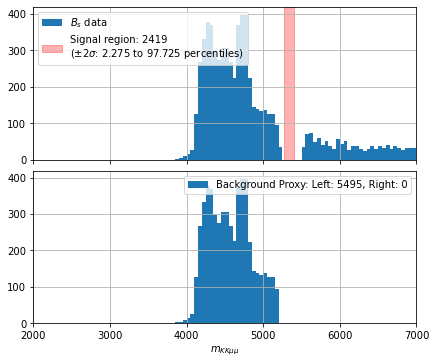

In [18]:
Bs_background_df = get_and_plot_background_data(Bs_df)

## Expected background in signal region

In [19]:
def find_expected_background_in_signal(background_data_frame):
    """
    Calculates the expected background in the signal region.
    
    Calculates the average density of candidates in the L left bins and R right bins.
    Extrapolates the average density across the width of the signal region.

    Here, L = 14879, R = 0.
    """
    bg_mass = background_data_frame._kkmumu_mass

    bin_width = 50
    left_bins = 6465
    right_bins = 0

    count_left = ((bg_mass > Bs_signal_region[0] - left_bins * bin_width) & (bg_mass < Bs_signal_region[0])).sum()
    count_right = ((bg_mass < Bs_signal_region[1] + right_bins * bin_width) & (bg_mass > Bs_signal_region[1])).sum()

    print(f"Left: {count_left} / {bin_width * left_bins} MeV")
    print(f"Right: {count_right} / {bin_width * right_bins} MeV")
    average_density = (count_left + count_right) / ((left_bins + right_bins) * bin_width)
    print(f"Average density: {average_density:.3f} / MeV")

    signal_region_width = Bs_signal_region[1] - Bs_signal_region[0]
    expected_background_in_signal = average_density * signal_region_width
    print(f"Expected background in signal region: {expected_background_in_signal:.2f}")
    return expected_background_in_signal


In [20]:
expected_background_in_signal = find_expected_background_in_signal(Bs_background_df)

Left: 5495 / 323250 MeV
Right: 0 / 0 MeV
Average density: 0.017 / MeV
Expected background in signal region: 2.24


# Machine Learning Classification

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def get_x_and_y():
    
    cut_signal = Bs_df_signal
    signal = cut_signal.loc[:, BDT_COLUMNS]
    background = Bs_background_df.loc[:, BDT_COLUMNS]

    x = pd.concat([signal, background], axis=0, ignore_index=True)
    y1, y2 = np.ones(len(signal)), np.zeros(len(background))
    y = np.concatenate([y1, y2], axis=None)
    return x, y


In [30]:
X, y = get_x_and_y()
print(f"X: {X.to_numpy().shape}")
print(f"y: {y.shape}. ({np.unique(y, return_counts=True)})")

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

## Punzi Figure of Merit

The figure of merit used to choose the threshold at which to cut on.

To maximise the sensitivity of the investigation, the figure of merit 

$\frac{\mathrm{TPR}}{\frac{a}{2} + \sqrt{\mathrm{FPR} \times B}}$

has to be maximised.

Here, $a$ represents TODO and $\mathrm{FPR} \times B$ represents the expected background remaining in the signal region after the cut.

In [ ]:
a = 0.5
B = expected_background_in_signal

def calculate_punzi_fom(y_test: np.ndarray, y_pred: np.ndarray, thresholds: np.ndarray):
    y_test_bool = y_test.astype(bool)

    P = y_test.sum()
    N = len(y_test) - P

    foms_data = defaultdict(list)
    for threshold in thresholds:
        y_pred_class = y_pred > threshold
        TP = y_pred_class[y_test_bool].sum()
        TPR = TP / P
        FP = y_pred_class[~y_test_bool].sum()
        FPR = FP / N
        fom = TPR / (a / 2 + (FPR * B) ** 0.5)
        for variable in ['P', 'N', 'TP', 'FP', 'TPR', 'FPR', 'fom']:
            foms_data[variable].append(eval(variable))
    return foms_data


## Classifier performance evaluation

Here, we evaluate the performance of different model types.

These evaluations result in a TPR and FPR and FoM that is our best estimate for the individual models trained later.

(It is highly likely that the individual models trained later report slightly misleading TPRs and FPRs and FoMs due to the small number of test data).

We use 2-fold CV (where the data is split into equal parts test and train) in an attempt to maximise the amount of test data so the classifier statistics can be better approximated.

Better results may be achieved using higher-fold CV (e.g. 4-fold CV, where the data would be split into 3/4 train and 1/4 test), but the calculated model performance statistics would then be even more unreliable.



### Function definitions

Trains and evaluates many models using a specific strategy (e.g. 2-Fold CV).

In the plots generated, each grey line represents the performance of a single model that has been trained on one randomly-sampled half of the data and tested on the remaining half.

The figure of merit (FoM) is aggregated in two forms:
1. Calculated for each model, and the mean of all the individual FoMs is taken (orange)
2. The mean TPR and mean FPR across all models is taken, and a single FoM is calculated from this (green)

We use the threshold that maximises the second, as we also use the mean TPR and 
mean FPR in our efficiency/expected background calculations.

The first method is also extremely sensitive to the low amount of data, which pushes many FPRs to 0 prematurely.

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from collections import defaultdict
import tqdm as tqdm
import scipy as sp


def get_foms(classifier, n_repeats: int = 100, n_splits: int = 2, weight_classes: bool = True):
    X, y = get_x_and_y()

    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)

    thresholds = np.concatenate([np.linspace(0, 1, 200), np.linspace(0.95, 1, 100)])
    thresholds.sort()

    foms_datas = []
    for i, (train, test) in enumerate(tqdm.tqdm(cv.split(X, y), total=n_splits * n_repeats, desc='Split')):
        x_train = X.loc[train]
        y_train = y[train]
        y_train_bool = y_train.astype(bool)
        if weight_classes:
            sample_weight = get_sample_weight(y_train_bool)
            # print(f"{y_train_bool.sum()}, {(~y_train_bool).sum()}")
            classifier.fit(x_train, y_train, sample_weight=sample_weight)
        else:
            classifier.fit(x_train, y_train)

        x_test = X.loc[test]
        y_test = y[test]
        # y_test_bool = y_test.astype(bool)

        y_pred_probabilities = classifier.predict_proba(x_test)
        y_pred = y_pred_probabilities[:, 1]

        # print(f"Length: Train: {len(y_train)}, {y_train.sum()}; Test: {len(y_test)}, {y_test.sum()}. i: {i}")
        # print(f"Length: Train: {len(y_train)}, {y_train_bool.sum()} True; "
        #       f"Test: {len(y_test)}, {y_test_bool.sum()} True. i: {i}")

        foms_data = calculate_punzi_fom(y_test, y_pred, thresholds)
        foms_datas.append(foms_data)

    # print(foms_array.shape)
    # np.savez(npz_file, foms=foms_array, thresholds=thresholds)
    return foms_datas, thresholds


def plot_foms(foms_datas, thresholds):
    fig, (ax1, ax2,ax3) = plt.subplots(3, 1, sharex='all', figsize=(6, 7.5))
    runs = len(foms_datas)
    for i in range(runs):
        foms_data = foms_datas[i]
        foms = foms_data['fom']
        ax1.plot(thresholds, foms, lw=0.5, color='grey', alpha=0.1)
    
        ax2.plot(thresholds, foms_data['TPR'], '-', color='grey', alpha=0.1)
        ax2.plot(thresholds, foms_data['FPR'], '--', color='grey', alpha=0.1)
        
        ax3.plot(foms_data['FPR'], foms_data['TPR'], color='grey', alpha=0.1)
        

    foms_array = np.array([data['fom'] for data in foms_datas])
    foms_medians = np.median(foms_array, axis=0)
    # ax1.plot(thresholds, foms_medians, 'C0', lw=3, alpha=0.5, label='Median')
    ax1.plot(thresholds, np.mean(foms_array, axis=0), 'C1', lw=3, alpha=0.5, label='Mean')

    tprs_array = np.array([data['TPR'] for data in foms_datas])
    tpr_medians = np.median(tprs_array, axis=0)
    tprs_means = np.mean(tprs_array, axis=0)
    # ax2.plot(thresholds, tpr_medians, 'C0', lw=3, alpha=0.5, label='TPR Median')
    ax2.plot(thresholds, tprs_means, 'C1', lw=3, alpha=0.5, label='TPR Mean')

    fprs_array = np.array([data['FPR'] for data in foms_datas])
    fprs_medians = np.median(fprs_array, axis=0)
    fprs_means = np.mean(fprs_array, axis=0)
    # ax2.plot(thresholds, fprs_medians, 'C0--', lw=3, alpha=0.5, label='FPR Median')
    ax2.plot(thresholds, fprs_means, 'C1--', lw=3, alpha=0.5, label='FPR Mean')
    ax3.plot(fprs_means,tprs_means,'C1--', lw=3, alpha=0.5, label='ROC',color="indianred")
    
    AUROC=sp.integrate.trapz(tprs_means,fprs_means)
    
    print("AUROC: ",abs(AUROC))

    foms_from_means = tprs_means / (a / 2 + (fprs_means * B) ** 0.5)
    ax1.plot(
        thresholds,
        foms_from_means,
        'C2', lw=3, alpha=0.5,
        label='FoM from stat means'
    )

    foms_argmax = foms_from_means.argmax()
    threshold_max = thresholds[foms_argmax]
    ax1.axvline(
        threshold_max, 
        label=f'FoM max: {foms_from_means.max():.3f} at {threshold_max:.3f}', 
        color='k', 
        lw=1, 
        alpha=0.5
    )
    ax2.axvline(
        threshold_max, 
        color='k', 
        lw=1, 
        alpha=0.5
    )
    print(f'Medians: \tTPR: {tpr_medians[foms_argmax]:.3f}. FPR: {fprs_medians[foms_argmax]:.3f} (at {threshold_max:.3f})')
    print(f'Means:   \tTPR: {tprs_means[foms_argmax]:.3f}. FPR: {fprs_means[foms_argmax]:.3f} (at {threshold_max:.3f})')

    print(f'FoMs from means: {foms_from_means[foms_argmax]:.3f}  (at {threshold_max:.3f})')

    ax1.grid()
    ax2.grid()
    ax3.grid()

    ax2.set_xlabel("Classifier Threshold")
    
    ax1.set_ylabel("Figure of Merit")
    ax2.set_ylabel("Rates")
    
    ax3.set_xlabel("FPR")
    ax3.set_ylabel("TPR")
    
    
    ax1.legend(loc=2)
    ax2.legend(loc=10)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 5)
    ax2.set_ylim(0, 1)
    plt.tight_layout(pad=0.5)
    plt.show()

    mean_tpr = tprs_means[foms_argmax]
    mean_fpr = fprs_means[foms_argmax]
    return threshold_max, mean_tpr, mean_fpr


In [ ]:
def get_sample_weight(y_bool):
    sample_weight = np.zeros_like(y_bool, dtype=np.float32)
    normalisation = len(y_bool)

    sample_weight[y_bool] =  normalisation / y_bool.sum()
    sample_weight[~y_bool] =  normalisation / (~y_bool).sum()
    return sample_weight


### XGBoost

In [ ]:
import xgboost

In [ ]:
# Ensures the classes are weighted equally despite imbalanced samples.
scale_pos_weight = (y==0).sum() / (y==1).sum() * 0.5
scale_pos_weight

#### XGBoost with Dart Booster

In [ ]:
def train_dart_booster():
    xgb = xgboost.XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        booster='dart'
    )
    foms_datas, thresholds = get_foms(xgb, n_repeats=200, weight_classes=False)
    threshold, tpr, fpr=plot_foms(foms_datas, thresholds)
    return threshold, tpr, fpr

threshold, tpr, fpr=train_dart_booster()

## Classifier training and saving
Training and evaluation of actual models to be used

In [ ]:
from sklearn.model_selection import StratifiedKFold
import pickle

def train_model(classifier, plot=False, save=False, is_xgb: bool = False, info_at_threshold=None, n_splits=2):
    X, y = get_x_and_y()

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True)
    thresholds = np.linspace(0, 1, 500)
    if info_at_threshold :
        if info_at_threshold not in thresholds:
            thresholds = np.sort(np.concatenate([thresholds, [info_at_threshold]]))
        info_at_threshold_index = (thresholds == info_at_threshold).argmax()

  
    foms_datas = []
    y_test_bools = []
    y_test_preds = []
    for i, (train, test) in enumerate(cv.split(X, y)):
        x_train = X.loc[train]
        y_train = y[train]
        y_train_bool = y_train.astype(bool)

        if is_xgb:
            classifier.fit(x_train, y_train)
        else:
            sample_weight = get_sample_weight(y_train_bool)
            classifier.fit(x_train, y_train, sample_weight=sample_weight)

        x_test = X.loc[test]
        y_test = y[test]
        y_test_bool = y_test.astype(bool)

        # print(f"Length: Train: {len(y_train)}, {y_train.sum()}; Test: {len(y_test)}, {y_test.sum()}. i: {i}")
        prob = classifier.predict_proba(x_test)
        y_pred = prob[:, 1]
        foms_data = calculate_punzi_fom(y_test, y_pred, thresholds)
        foms_datas.append(foms_data)
        if info_at_threshold:
            print(f"Info at threshold: {info_at_threshold:.3f}:")
            for k, v in foms_data.items():
                print(f"\t{k}: {v[info_at_threshold_index]:.3f}")

        y_test_bools.append(y_test_bool)
        y_test_preds.append(y_pred)

        if save:
            file_name = f"classifier_MC_phimumu{i}"
            if is_xgb:
                classifier.save_model(f"{file_name}.json")
            else:
                with open(f"{file_name}.pkl", "wb") as f:
                    pickle.dump(classifier, f)

    if plot:
        plot_model_performance(foms_datas, thresholds, y_test_bools, y_test_preds, classifier,Bs_df)

def plot_model_performance(foms_datas, thresholds, y_test_bools, y_test_preds, classifier,data_frame):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex='all', figsize=(6, 5))
    runs = len(foms_datas)
    
    df=data_frame.loc[(data_frame['Bs_M']>5200) & (data_frame['Bs_M']<5450)]
    model_x = df.loc[:, BDT_COLUMNS]
    model_y_pred =  classifier.predict_proba(model_x)[:, 1]
    
    for i in range(runs):
        classifier_i = i + 1
        foms_data = foms_datas[i]
        foms = foms_data['fom']
        ax1.plot(thresholds, foms, lw=1, color=f'C{i}', alpha=0.5, label=f"Classifier {classifier_i}")
    
        ax2.plot(thresholds, foms_data['TPR'], '-', color=f'C{i}', alpha=0.7, label=f'TPR {classifier_i}')
        ax2.plot(thresholds, foms_data['FPR'], '--', color=f'C{i}', alpha=0.7, label=f'FPR {classifier_i}')

    tprs_array = np.array([data['TPR'] for data in foms_datas])
    tprs_means = np.mean(tprs_array, axis=0)
    ax2.plot(thresholds, tprs_means, 'C1', lw=3, alpha=0.5, label='TPR Mean')

    fprs_array = np.array([data['FPR'] for data in foms_datas])
    fprs_means = np.mean(fprs_array, axis=0)
    ax2.plot(thresholds, fprs_means, 'C1--', lw=3, alpha=0.5, label='FPR Mean')

    foms_from_means = tprs_means / (a / 2 + (fprs_means * B) ** 0.5)
    ax1.plot(
        thresholds,
        foms_from_means,
        'r', lw=3, alpha=0.5,
        label='FoM from stat means'
    )

    ax1.grid()
    ax2.grid()
    ax2.set_xlabel("Classifier Threshold")
    ax1.set_ylabel("Figure of Merit")
    ax2.set_ylabel("Rates")
    ax1.legend()
    ax2.legend()
    plt.tight_layout()

    
    
    
    fig, axs = plt.subplots(runs, 1, figsize=(6, 5), sharex='all')
    for i in range(runs):
        ax = axs[i]
        y_test_bool = y_test_bools[i]
        y_test_pred = y_test_preds[i]
        plot_range = [0, 1]
        ax.hist(model_y_pred, bins=20, range=plot_range, label='Data', alpha=1,color="green")
        ax.hist(y_test_pred[~y_test_bool], bins=20, range=plot_range, label='Not event', alpha=0.8,color="lightcoral")
        ax.hist(y_test_pred[y_test_bool], bins=20, range=plot_range, label='Event', alpha=0.5,color="dodgerblue")
        ax.legend(loc=9)
        ax.grid()
        ax.set_yscale('log')
    plt.xlabel('Score')
    plt.tight_layout()
    plt.show()
    

    fig = plt.figure()
    y_test_bool = y_test_bools[0]
    y_test_pred = y_test_preds[0]
    plot_range = [0, 1]
    plt.hist(model_y_pred, bins=20, range=plot_range, label='Data', alpha=0.8,color="green")
    plt.hist(y_test_pred[~y_test_bool], bins=20, range=plot_range, label='Background Sample', alpha=1,color="orange")
    plt.hist(y_test_pred[y_test_bool], bins=20, range=plot_range, label='MC Signal', alpha=0.5,color="dodgerblue")
    plt.legend(loc=9)
    plt.grid()
    plt.yscale('log')
    plt.xlabel('Score')
    plt.tight_layout()
    plt.show()
    
    
    plt.figure(figsize=(6, 6))
    feature_importance = classifier.feature_importances_
    sorted_indices = np.argsort(feature_importance)
    pos = np.arange(sorted_indices.shape[0]) + .5
    plt.barh(pos, feature_importance[sorted_indices])
    plt.yticks(pos, X.columns[sorted_indices])
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()


In [ ]:
np.random.seed(37621)
xgb = xgboost.XGBClassifier(scale_pos_weight=scale_pos_weight)
train_model(classifier=xgb, plot=True, save=True, is_xgb=True, info_at_threshold=threshold)


# Branching Fraction

## Applying ML model to data

In [ ]:
def plot_mass_distributions(data_frame, bins='auto'):
    bs_kkmumu_mass_cut_mask = get_bs_kkmumu_mass_cut_mask(data_frame)
    plt.figure(figsize=[6,3])
    plot_range = (5000, 6000)
    plt.hist(data_frame._kkmumu_mass, bins=bins, range=plot_range)
    plt.axvline(_kkmumu_mass, color='k', alpha=0.5)
    plt.xlabel(r'$m_{KK\mu\mu}$')
    plt.xlim(plot_range)


In [ ]:
def apply_and_plot_ml_model(classifier, threshold, data_frame, expected_FPR):
    
    model_x = data_frame.loc[:, BDT_COLUMNS]
    model_y_pred =  classifier.predict_proba(model_x)[:, 1]
    model_y_pred_class = model_y_pred > threshold

    after_model_data_frame = data_frame.loc[model_y_pred_class]
    plot_mass_distributions(after_model_data_frame, 100)
    plot_mass_distributions(data_frame, 100)
    plt.axvspan(*Bs_signal_region, color='C5', alpha=0.3)

    print(f"Total remaining: {len(after_model_data_frame)}")

    bs_kkmumu_mass_cut_mask = get_bs_kkmumu_mass_cut_mask(after_model_data_frame)
    after_model_after_kkmumu_mass_cut = after_model_data_frame.loc[bs_kkmumu_mass_cut_mask]
    print(f"After Bs=KKmumu mass cut: {len(after_model_after_kkmumu_mass_cut)}")

    remaining_in_signal_region = after_model_after_kkmumu_mass_cut.loc[
        (after_model_after_kkmumu_mass_cut._kkmumu_mass > Bs_signal_region[0]) 
        & (after_model_after_kkmumu_mass_cut._kkmumu_mass < Bs_signal_region[1])
    ]
    remaining_in_signal_region.to_pickle("remaining_in_signal_region.pkl.gz")

    print(f"Total remaining in signal region: {len(remaining_in_signal_region)}")

    print(f"Expected background in signal region: {B:.3f} (before ML classifier), {B * expected_FPR:.3f} (after ML classifier)")
    return len(remaining_in_signal_region),after_model_data_frame


In [ ]:
import xgboost

xgb = xgboost.XGBClassifier()
xgb.load_model('classifier_MC_phimumu0.json')
remaining_in_signal_region,after_model_data_frame = apply_and_plot_ml_model(xgb, threshold=threshold, data_frame=Bs_df, expected_FPR=fpr)
plt.savefig('cleaned_data_after_ml_model.png', dpi=300)


Let's now compare the data before and after the ML classifier is applied for the dimuon and dikaon mass distributions

In [ ]:
model_x = Bs_df.loc[:, BDT_COLUMNS]
model_y_pred =  xgb.predict_proba(model_x)[:, 1]
model_y_pred_class = model_y_pred > threshold

model_x_MC = Bs_df_signal.loc[signal_mask].loc[:, BDT_COLUMNS]
model_y_pred_MC =  xgb.predict_proba(model_x_MC)[:, 1]
model_y_pred_class_MC = model_y_pred_MC > threshold

#after_model_data_frame = Bs_df.loc[model_y_pred_class]
after_model_MC=Bs_df_signal.loc[signal_mask].loc[model_y_pred_class_MC]

print(threshold)
phimumumask=(((after_model_data_frame['phi_M']>998) & (after_model_data_frame['phi_M']<1040) & (after_model_data_frame['_kkmumu_mass']>5250) & (after_model_data_frame['_kkmumu_mass']<5450))  
            & ((after_model_data_frame['jpsi_M']<3685) | (after_model_data_frame['jpsi_M']>3687)) & ((after_model_data_frame['jpsi_M']<3000) | (after_model_data_frame['jpsi_M']>3150)))


plt.figure(figsize=[6,3])
plt.hist(after_model_data_frame['jpsi_M'],bins=100,range=[2500,3600])
plt.hist(Bs_df['jpsi_M'],bins=100,range=[2500,4500],alpha=0.5)

plt.figure(figsize=[6,3])
plt.hist(after_model_data_frame['phi_M'],bins=100,range=[800,2500])
plt.hist(Bs_df['phi_M'],bins=100,range=[800,2500],alpha=0.5)
plt.show()

plt.figure(figsize=[6,3])
#plt.hist2d(after_model_data_frame.loc[phijpsimask]['jpsi_M'],after_model_data_frame.loc[phimumumask]['Bs_M'],bins=100)
plt.show()

plt.figure(figsize=[6,3])
n,bins,patches=plt.hist(after_model_data_frame['Bs_M'],bins=30,range=[5250,5600])
plt.show()


plt.figure(figsize=[6,3])
plt.hist(after_model_MC['Bs_M'],bins=100,range=[5250,5600])
plt.hist(Bs_df_signal.loc[signal_mask]['Bs_M'],bins=100,range=[5250,5600],alpha=0.5)
plt.show()

print("2018 events pre BDT: ",len(Bs_df['Bs_M']))
print("2018 events retained: ",len(after_model_data_frame['Bs_M']))

print("MC events pre BDT: ",len(Bs_df_signal['Bs_M']))
print("MC events retained: ",len(after_model_MC['Bs_M']))

## Fitting $\phi \mu \mu$ events in 2018 data

In [ ]:
from scipy.optimize import curve_fit
from scipy.stats import crystalball


def gaussian(x,mu,sigma,A):
    return A*np.exp(-((x-mu)**2)/(2*sigma**2))

def combinatorial(x,c,alpha,B):
    return B*np.exp(-alpha*(x-c))

def fitting_function(x,mu,sigma,A,c,alpha,B):
    return gaussian(x,mu,sigma,A)+combinatorial(x,c,B,alpha)
    #return A*crystalball.pdf(-x+mu,beta,sigma)+combinatorial(x,c,B,alpha)

def fitting_function2(x,A,c,alpha,B):
    return gaussian(x,5.36512535e+03,1.77782300e+01,A)+combinatorial(x,c,B,alpha)
    
n1,bins1,patches1=plt.hist(after_model_MC['Bs_M'],bins=30,range=[5250,5600])

xaxis=np.linspace(bins1[0],bins1[-1],len(n1))
xaxis_plot=np.linspace(bins1[0],bins1[-1],1000)
popt, pcov = curve_fit(fitting_function, xaxis, n,p0=[5.36512535e+03,1.77782300e+01,50,0,1,1])

print(popt)
plt.figure()
plt.plot(xaxis_plot, fitting_function(xaxis_plot, *popt))
n,bins,patches=plt.hist(after_model_data_frame.loc[phijpsimask]['Bs_M'],bins=30,range=[5250,5600])
#plt.hist(after_model_MC['Bs_M'],bins=50,range=[5000,6000])
plt.show()